# DP3: Code

By Ashish Dhanalakota and Matthew Pactol

This is the code we used to control and simulate our spacecraft, and to plot its motion.

The first step is to import all the packages we need. `numpy`, `sympy`, and `scipy` help with creating our initial matrices and finding the K matrices and eigenvalues that we seek to use. `time` helps with the simulation of our segbot. `matplotlib` helps with plotting the motion of the segbot. `ae353_spacecraft_design` and `ae353_spacecraft_simulate` are needed to run and display the PyBullet simulator we use.

In [196]:
# Standard modules
import time
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt

# This is to find our gain matrix
from scipy import linalg

# Professor Bretl's script to design and simulate the spacecraft
import ae353_spacecraft_design as design
import ae353_spacecraft_simulate

Define the LQR method as a function of the `A`, `B`, `Q`, and `R` matrices. This function will be useful for finding gain matrices for the controller and observer.

In [197]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K

# Create Dynamic Model

Create a visualizer to help with placement of reaction wheels.

In [198]:
# Create the visualizer
vis = design.create_visualizer()

# Show the visualizer in this notebook
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


Specify the location of each reaction wheel in terms of its right ascension  𝛼
  and declination  𝛿
 :

In [199]:
wheels = [
    {'alpha': 1 * np.pi / 2, 'delta': np.pi/2},
    {'alpha': 1 * np.pi / 3, 'delta': -(19.5/180)*np.pi},
    {'alpha': 3 * np.pi / 3, 'delta': -(19.5/180)*np.pi},
    {'alpha': 5 * np.pi / 3, 'delta': -(19.5/180)*np.pi},
]

Show wheels in the visualizer, and create a model of the spacecraft in URDF format.

In [200]:
design.show_wheels(vis, wheels)
design.create_spacecraft(wheels)

Specify the physical parameters.

In [201]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 2.2

Derive the equations of motion:

In [202]:
# Define yaw, pitch, roll angles
psi, theta, phi = symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * Matrix(wheels[0]['xyz'])
T2 = - tau_2 * Matrix(wheels[1]['xyz'])
T3 = - tau_3 * Matrix(wheels[2]['xyz'])
T4 = - tau_4 * Matrix(wheels[3]['xyz'])
T = nsimplify(T1 + T2 + T3 + T4)

# Define MOI of spacecraft and wheels together
Jx = nsimplify(Jxb + 4 * mw * lw**2)
Jy = nsimplify(Jyb + 4 * mw * lw**2)
Jz = nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = simplify(Matrix.vstack(M * Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

View the `f` matrix.

In [203]:
f

Matrix([
[                                                                                                                                                                          (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                       w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                           w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-37673304933744975*tau_1/134092775225110342745188083401718967053431810818048 - 5184528201007*tau_2/146800000000000 + 207381128040279*tau_3/2936000000000000 - 5184528201007*tau_4/146800000000000 - 75*w_y*w_z/367],
[     -134711147906209*tau_1/29360000000000000000000000000000 - 35919465029671*tau_2/587200000000000 - 50793726931619*tau_3/58720000000

Calculate `A` and `B` matrices.

In [204]:
# Equilibrium points
psie = 0 # yaw angle (rad)
thetae = 0 # pitch angle (rad)
phie = 0 # roll angle (rad)
w_xe = 0 # angular velocity about the body's x-axis (rad/s)
w_ye = 0 # angular velocity about the body's y-axis (rad/s)
w_ze = 0 # angular velocity about the body's z-axis (rad/s)
tau_1e = 0 # torque applied to Reaction Wheel 1 (N*m)
tau_2e = 0 # torque applied to Reaction Wheel 2 (N*m)
tau_3e = 0 # torque applied to Reaction Wheel 3 (N*m)
tau_4e = 0 # torque applied to Reaction Wheel 4 (N*m)

A_jac = f.jacobian([psi, theta, phi, w_x, w_y, w_z])
B_jac = f.jacobian([tau_1, tau_2, tau_3, tau_4])

A_num = lambdify([psi, theta, phi, w_x, w_y, w_z], A_jac)
B_num = lambdify([tau_1, tau_2, tau_3, tau_4], B_jac)

A = A_num(psie, thetae, phie, w_xe, w_ye, w_ze)
B = B_num(tau_1e, tau_2e, tau_3e, tau_4e)

B.tolist()

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [-2.809495505667649e-34,
  -0.03531694959814033,
  0.07063389919628031,
  -0.03531694959814033],
 [-4.588254356478508e-18,
  -0.061170751072328,
  -8.650157856202146e-18,
  0.061170751072328],
 [-0.06221719457013575,
  0.02076852630979344,
  0.02076852630979344,
  0.02076852630979344]]

Use the LQR method to calculate the `K` gain matrix.

In [205]:
# We choose Q and R values for the controller
Q = np.diag([100, 100, 100, 100, 100, 100])

R = np.diag([1, 1, 1, 1])

# Use LQR method to find eigenvalues and a gain matrix
K = lqr(A, B, Q, R)

K

array([[-8.65717785e+00, -4.88345696e-16, -3.76629006e-15,
        -1.06274009e-14,  1.96760544e-16, -1.68379086e+01],
       [ 2.88982535e+00, -7.07106781e+00, -4.08248290e+00,
        -7.42957086e+00, -1.28683942e+01,  5.62060940e+00],
       [ 2.88982535e+00,  6.38566595e-16,  8.16496581e+00,
         1.48591417e+01,  2.39780022e-15,  5.62060940e+00],
       [ 2.88982535e+00,  7.07106781e+00, -4.08248290e+00,
        -7.42957086e+00,  1.28683942e+01,  5.62060940e+00]])

# Create Sensor Model

In order to derive the sensor model, the spacecraft must be simulated beforehand. This will be done using the PyBullet simulator. The `seed` is set to a random number so that our results are able to be replicated.

In [323]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=4659,
)

Symbolic variables for right ascension  𝛼
  and declination  𝛿
  of each star:

In [207]:
alpha, delta = symbols('alpha, delta')

Specify the physical parameters:

In [208]:
# Scope radius
r = 0.8 / 2.1

Derive the sensor model:

In [209]:
# Position of star in space frame
p_star_in_space = Matrix([[cos(alpha) * cos(delta)],
                          [sin(alpha) * cos(delta)],
                          [sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / nsimplify(r)) * Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                               [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = Matrix([[],[]])

for (i, star) in enumerate(simulator.stars):
    p_star_in_image = (1 / nsimplify(r)) * Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                               [p_star_in_body[2] / p_star_in_body[0]]])
    image_with_subs = p_star_in_image.subs(alpha, star["alpha"]).subs(delta, star["delta"])
    g = Matrix.vstack(g, image_with_subs)

View the `g` matrix.

In [210]:
g

Matrix([
[21*(-0.0987123949919223*sin(phi)*sin(psi)*sin(theta) + 0.983831341052805*sin(phi)*sin(theta)*cos(psi) - 0.149438132473599*sin(phi)*cos(theta) - 0.983831341052805*sin(psi)*cos(phi) - 0.0987123949919223*cos(phi)*cos(psi))/(8*(-0.0987123949919223*sin(psi)*cos(theta) + 0.149438132473599*sin(theta) + 0.983831341052805*cos(psi)*cos(theta)))],
[ 21*(0.983831341052805*sin(phi)*sin(psi) + 0.0987123949919223*sin(phi)*cos(psi) - 0.0987123949919223*sin(psi)*sin(theta)*cos(phi) + 0.983831341052805*sin(theta)*cos(phi)*cos(psi) - 0.149438132473599*cos(phi)*cos(theta))/(8*(-0.0987123949919223*sin(psi)*cos(theta) + 0.149438132473599*sin(theta) + 0.983831341052805*cos(psi)*cos(theta)))],
[                                                                                                                                    21*(0.988771077936042*sin(phi)*sin(theta)*cos(psi) - 0.149438132473599*sin(phi)*cos(theta) - 0.988771077936042*sin(psi)*cos(phi))/(8*(0.149438132473599*sin(theta) + 0.98877107793

Calculate the `C` and `D` matrices.

In [211]:
C_jac = g.jacobian([psi, theta, phi, w_x, w_y, w_z])
D_jac = g.jacobian([tau_1, tau_2, tau_3, tau_4])

C_num = lambdify([psi, theta, phi, w_x, w_y, w_z], C_jac)
D_num = lambdify([tau_1, tau_2, tau_3, tau_4], D_jac)

C = C_num(psie, thetae, phie, w_xe, w_ye, w_ze)
D = D_num(tau_1e, tau_2e, tau_3e, tau_4e)

D.shape

(14, 4)

Use the LQR to calculate the `L` gain matrix.

In [212]:
Qo = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Ro = np.diag([1, 1, 1, 1, 1, 1])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

L.shape

(6, 14)

View the eigenvalues of the `K` and `L` matrices. If these values are all negative, then our controller and observer are fully controllable.

In [213]:
K_vals = linalg.eigvals(A - B @ K)
L_vals = linalg.eigvals(A - C.T @ L.T)

print(K_vals.tolist())
print()
print(L_vals.tolist())

[(-0.6989013800157483+0.4798066498256619j), (-0.6989013800157483-0.4798066498256619j), (-0.787169339007059+0.4954285918248347j), (-0.787169339007059-0.4954285918248347j), (-0.7871693390070588+0.4954285918248333j), (-0.7871693390070588-0.4954285918248333j)]

[(-7.922733303652345+0j), (-8.020559059403956+0j), (-1.8559750826500578+0j), 0j, 0j, 0j]


# Controller and Trials

Find the location of each star.

In [214]:
for (i, star) in enumerate(simulator.stars):
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')
    print(star["alpha"])

star 0 : alpha = -0.10 : delta = -0.15
-0.1
star 1 : alpha =  0.00 : delta = -0.15
0.0
star 2 : alpha =  0.10 : delta = -0.15
0.1
star 3 : alpha =  0.00 : delta =  0.00
0.0
star 4 : alpha = -0.10 : delta =  0.15
-0.1
star 5 : alpha =  0.00 : delta =  0.15
0.0
star 6 : alpha =  0.10 : delta =  0.15
0.1


Define the controller.

In [272]:
class Controller:
    def __init__(self):   
        self.variables_to_log = ['xhat']
        self.dt = 1/25
    
    def reset(self):
        self.xhat = np.array([0., 0., 0., 0., 0., 0.])
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        
        u = - K @ self.xhat
        
        # FIXME: replace the following lines
        torque_1 = u[0]
        torque_2 = u[1]
        torque_3 = u[2]
        torque_4 = u[3]
        
        y = star_meas
        
        self.xhat += self.dt * (A @ self.xhat + B @ u - L @ (C @ self.xhat - y))
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [273]:
controller = Controller()

Define the number of trials that will be run by simulator before it stops.

In [274]:
trials = 1000

# Simulation 1: Initial Conditions at Equilibrium

The simulation has already started running from the beginning of the previous section.

Define arrays to store data of the following:
* Simulation duration: `times`
* Yaw RMSE: `yaw_errors`
* Pitch RMSE: `pitch_errors`
* Roll RMSE: `roll_errors`

In [275]:
times = np.array([])
yaw_errors = np.array([])
pitch_errors = np.array([])
roll_errors = np.array([])

Run the simulator for the number of times defined by `trials`. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [276]:
for i in range(1, trials + 1):
    
    # Reset the simulator with initial conditions at equilibirum
    simulator.reset(
        orientation={
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
        },
        angular_velocity={
            'x': 0.,
            'y': 0.,
            'z': 0.,
        },
        scope_noise=0.1,
    )
    
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    data = simulator.run(
        controller,      
        max_time=500.0, 
        data_filename=None, 
        video_filename=None, 
        print_debug=False, 
    )
    
    # Store data into the arrays defined above
    times = np.append(times, data['t'][-1])
    yaw_errors = np.append(yaw_errors, np.sqrt(np.mean((data['yaw'])**2)))
    pitch_errors = np.append(pitch_errors, np.sqrt(np.mean((data['pitch'])**2)))
    roll_errors = np.append(roll_errors, np.sqrt(np.mean((data['roll'])**2)))
      
    # DELETE
    if (np.mod(i, 50) == 0):
        print(i)

50
100


# Simulation 1 Histograms 

Show a histogram of the run times of the trials run above.

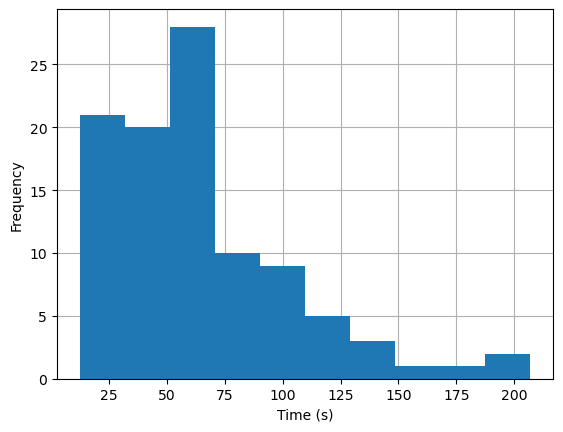

In [277]:
# TIMES

plt.hist(times, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the yaw RMSE of the trials run above.

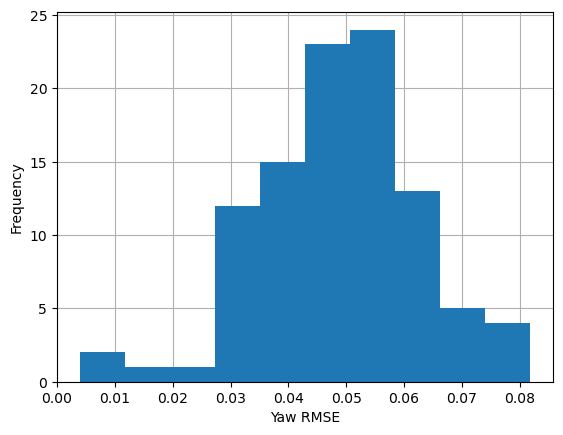

In [278]:
# YAW RMSE

plt.hist(yaw_errors, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Yaw RMSE')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the pitch RMSE of the trials run above.

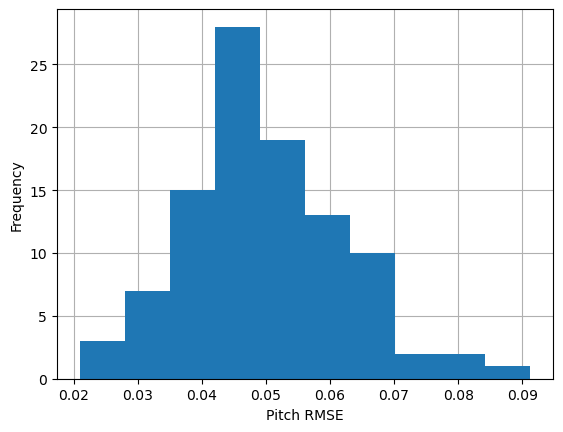

In [279]:
# PITCH RMSE

plt.hist(pitch_errors, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Pitch RMSE')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the roll RMSE of the trials run above.

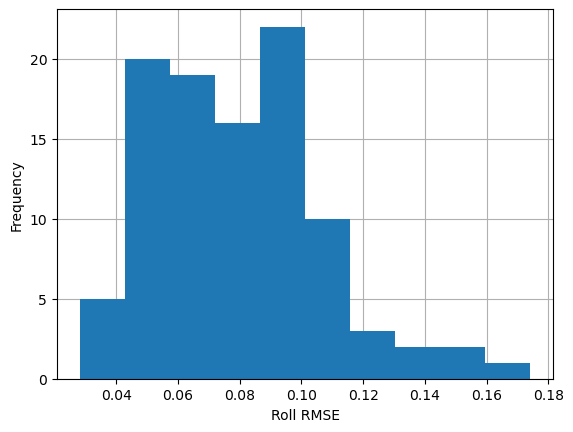

In [280]:
# ROLL RMSE

plt.hist(roll_errors, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Roll RMSE')
plt.ylabel('Frequency')
plt.show()

Print average and median for the run time, yaw RMSE, pitch RMSE, and roll RMSE.

In [281]:
print('Average times: ', np.average(times))
print('Median times: ', np.median(times))
print('Average yaw RMSE: ', np.average(yaw_errors))
print('Median yaw RMSE: ', np.median(yaw_errors))
print('Average pitch RMSE: ', np.average(pitch_errors))
print('Median pitch RMSE: ', np.median(pitch_errors))
print('Average roll RMSE: ', np.average(roll_errors))
print('Median roll RMSE: ', np.median(roll_errors))

Average times:  64.71039999999999
Median times:  59.519999999999996
Average yaw rmse:  0.04882040934185504
Median yaw rmse:  0.048577783748451495
Average pitch rmse:  0.04990138701786163
Median pitch rmse:  0.04815170727925967
Average roll rmse:  0.07979506984743794
Median roll rmse:  0.07693897814011001


# Simulation 2: Random Initial Conditions

Define arrays to store data of the following:
* Simulation duration: `times_2`
* Yaw RMSE: `yaw_errors_2`
* Pitch RMSE: `pitch_errors_2`
* Roll RMSE: `roll_errors_2`

In [218]:
times_2 = np.array([])
yaw_errors_2 = np.array([])
pitch_errors_2 = np.array([])
roll_errors_2 = np.array([])

Run the simulator for the number of times defined by `trials`.

In [219]:
for i in range(1, trials + 1):
    
    # Reset the simulator with random initial conditions
    simulator.reset(
        orientation=None,
        angular_velocity=None,
        scope_noise=0.1,
    )
    
    # Reset the controller
    controller.reset()
    
    # Run the simulation
    data = simulator.run(
        controller,      
        max_time=500.0, 
        data_filename=None, 
        video_filename=None, 
        print_debug=False, 
    )
    
    # Store data into the arrays defined above
    times_2 = np.append(times, data['t'][-1])
    yaw_errors_2 = np.append(yaw_errors, np.sqrt(np.mean((data['yaw'])**2)))
    pitch_errors_2 = np.append(pitch_errors, np.sqrt(np.mean((data['pitch'])**2)))
    roll_errors_2 = np.append(roll_errors, np.sqrt(np.mean((data['roll'])**2)))
      
    # DELETE
    if (np.mod(i, 50) == 0):
        print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


# Simulation 2 Histograms 

Show a histogram of the run times of the trials run above.

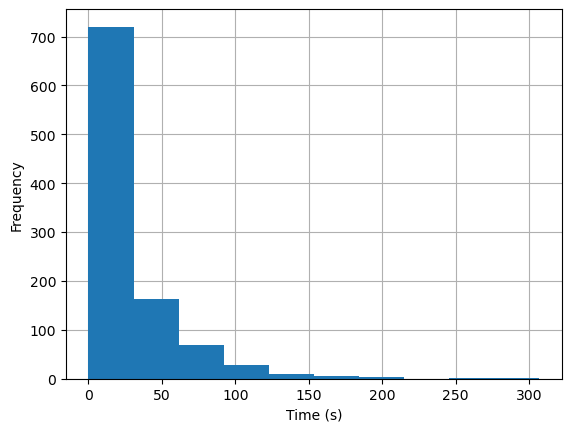

In [220]:
# TIMES

plt.hist(times_2, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the yaw RMSE of the trials run above.

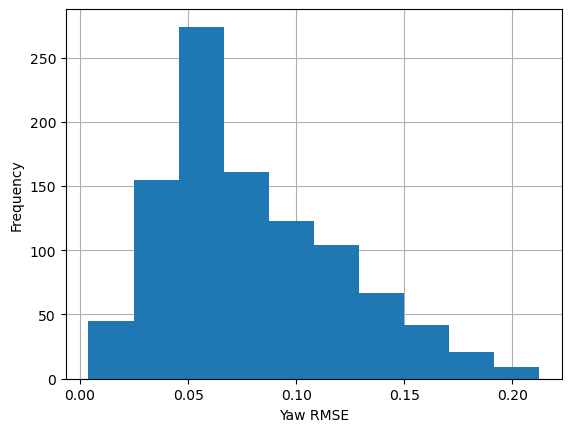

In [221]:
# YAW RMSE

plt.hist(yaw_errors_2, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Yaw RMSE')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the pitch RMSE of the trials run above.

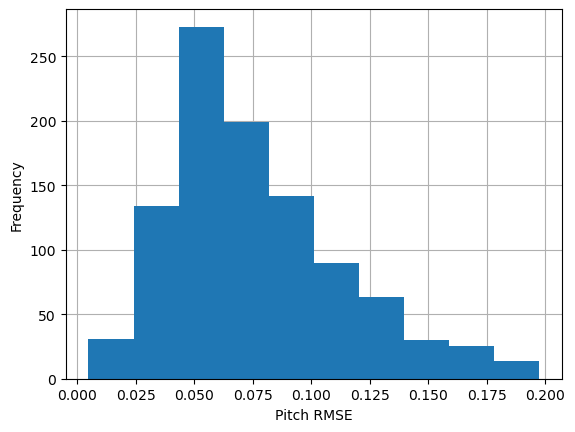

In [222]:
# PITCH RMSE

plt.hist(pitch_errors_2, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Pitch RMSE')
plt.ylabel('Frequency')
plt.show()

Show a histogram of the pitch RMSE of the trials run above.

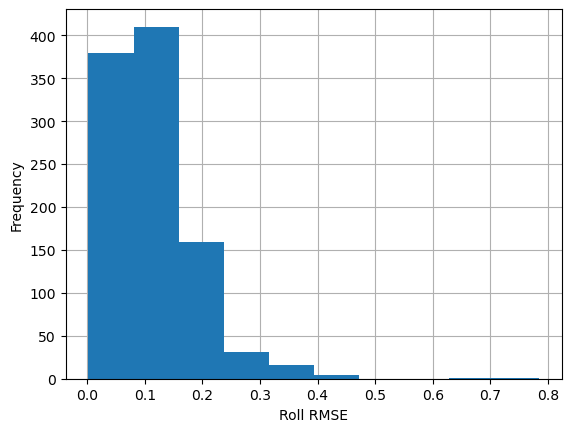

In [223]:
# ROLL RMSE

plt.hist(roll_errors_2, bins = 10, zorder = 2)
plt.grid(zorder = 0)
plt.xlabel('Roll RMSE')
plt.ylabel('Frequency')
plt.show()

Print average and median for the run time, yaw RMSE, pitch RMSE, and roll RMSE.

In [224]:
print('Average times: ', np.average(times_2))
print('Median times: ', np.median(times_2))
print('Average yaw RMSE: ', np.average(yaw_errors_2))
print('Median yaw RMSE: ', np.median(yaw_errors_2))
print('Average pitch RMSE: ', np.average(pitch_errors_2))
print('Median pitch RMSE: ', np.median(pitch_errors_2))
print('Average roll RMSE: ', np.average(roll_errors_2))
print('Median roll RMSE: ', np.median(roll_errors_2))

Average times:  22.22769230769231
Median times:  2.4
Average yaw rmse:  0.0798494249726346
Median yaw rmse:  0.06958583111713913
Average pitch rmse:  0.07596093183804435
Median pitch rmse:  0.06711334372077495
Average roll rmse:  0.11234047938958923
Median roll rmse:  0.09862231890086331


# Simulation 3: Finding State Estimate Error

To check that the observer is working, we will plot the error of state estimate over time. Specifically, we will plot the errors in yaw estimate, pitch estimate, and roll estimate over time.

Run the simulator once.

In [375]:
# Reset the simulator with random initial conditions
simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)

# Reset the controller
controller.reset()

# Run the simulation
data = simulator.run(
    controller,      
    max_time=500.0, 
    data_filename=None, 
    video_filename=None, 
    print_debug=False, 
)

Plot the yaw estimate and yaw as a function of time.

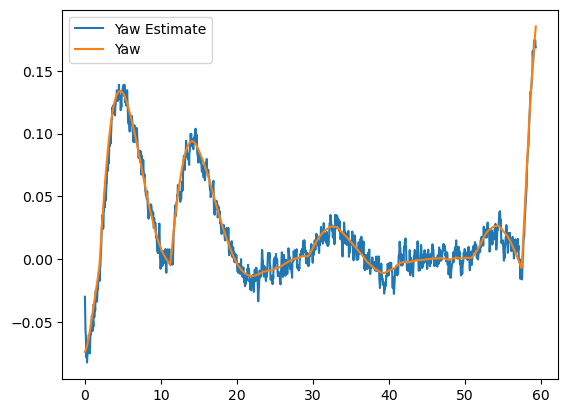

In [379]:
plt.plot(data['t'], data['xhat'][:,0], label='Yaw Estimate')
plt.plot(data['t'], data['yaw'], label='Yaw')
plt.legend()
plt.show()

Plot the pitch estimate and pitch as a function of time.

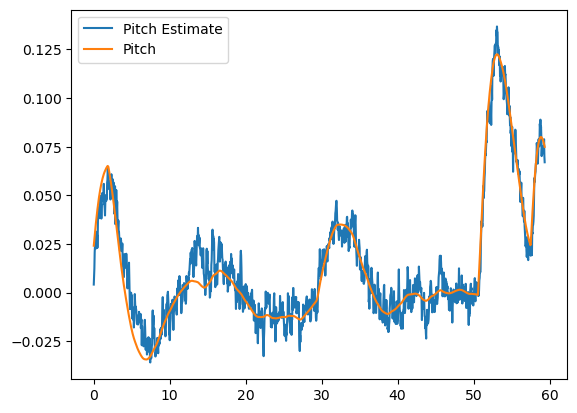

In [377]:
plt.plot(data['t'], data['xhat'][:,1], label='Pitch Estimate')
plt.plot(data['t'], data['pitch'], label='Pitch')
plt.legend()
plt.show()

Plot the roll estimate and roll as a function of time.

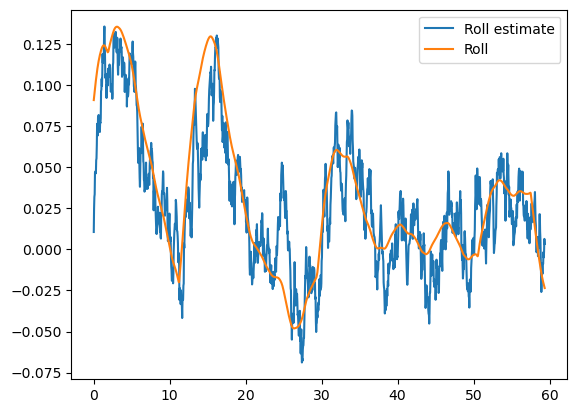

In [378]:
plt.plot(data['t'], data['xhat'][:,2], label='Roll estimate')
plt.plot(data['t'], data['roll'], label='Roll')
plt.legend()
plt.show()